In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from models import BreastPathQModel
from data_generator_boneage import BoneAgeDataset
from data_generator_breast import BreastPathQDataset
from data_generator_oct import OCTDataset
from data_generator_endovis import EndoVisDataset
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency
from utils import nll_criterion_gaussian
from skimage.exposure import equalize_adapthist as clahe
from glob import glob
from test import AuxModel, train_aux
%matplotlib notebook

In [2]:
base_model = 'densenet201'

In [3]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")
resize_to = (256, 256)

In [4]:
batch_size = 16

data_set = BoneAgeDataset(data_dir='/media/fastdata/laves/rsna-bone-age/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./data_indices/boneage_valid_indices.pth')
test_indices = torch.load('./data_indices/boneage_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([2000])
torch.Size([4000])


In [5]:
data_set = BreastPathQDataset(data_dir='/media/fastdata/laves/breastpathq/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

test_indices = torch.load('./data_indices/breastpathq_test_indices.pth')

print(test_indices.shape)

test_loader_breastpathq = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([600])


In [6]:
data_dir = '/media/fastdata/laves/oct_data_needle/data'
data_set = OCTDataset(data_dir=data_dir, augment=False, resize_to=resize_to)
assert len(data_set) > 0

test_indices = torch.load('./data_indices/oct_test_indices.pth')

print(test_indices.shape)

test_loader_oct = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([850])


In [7]:
data_dir = '/media/fastdata/laves/EndoVis15_instrument_tracking'
data_set_test = EndoVisDataset(data_dir=data_dir+'/test', augment=False, scale=0.5)

assert len(data_set_test) > 0
print(len(data_set_test))

test_loader_endovis = torch.utils.data.DataLoader(data_set_test, batch_size=batch_size, shuffle=False)

2232


In [8]:
model = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)

checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_boneage_2.pth.tar")[0]

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']))

Loading previous weights at epoch 485


In [9]:
model.eval()
y_p_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

        y_p_calib.append(y_p.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

100%|██████████| 125/125 [05:51<00:00,  2.81s/it]


In [10]:
y_p_calib = torch.cat(y_p_calib, dim=1).clamp(0, 1).permute(1,0,2)
mu_calib = y_p_calib.mean(dim=1)
var_calib = torch.cat(vars_calib, dim=0)
logvars_calib = torch.cat(logvars_calib, dim=1).permute(1,0,2)
logvar_calib = logvars_calib.mean(dim=1)
target_calib = torch.cat(targets_calib, dim=0)

In [11]:
err_calib = (target_calib-mu_calib).pow(2).mean(dim=1, keepdim=True).sqrt()
errvar_calib = (y_p_calib-target_calib.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

uncertainty = 'total'

uncert_calib_aleatoric = logvar_calib.exp().mean(dim=1, keepdim=True)
uncert_calib_epistemic = var_calib.mean(dim=1, keepdim=True)

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.sqrt().clamp(0, 1)
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total

In [12]:
print((err_calib**2).mean())
print(errvar_calib.mean())
print((uncert_calib**2).mean())
print(uncert_calib_aleatoric.sqrt().mean())
print(uncert_calib_epistemic.sqrt().mean())

err_calib = errvar_calib.sqrt()

tensor(0.0035, device='cuda:0')
tensor(0.0039, device='cuda:0')
tensor(0.0031, device='cuda:0')
tensor(0.0510, device='cuda:0')
tensor(0.0199, device='cuda:0')


<IPython.core.display.Javascript object>


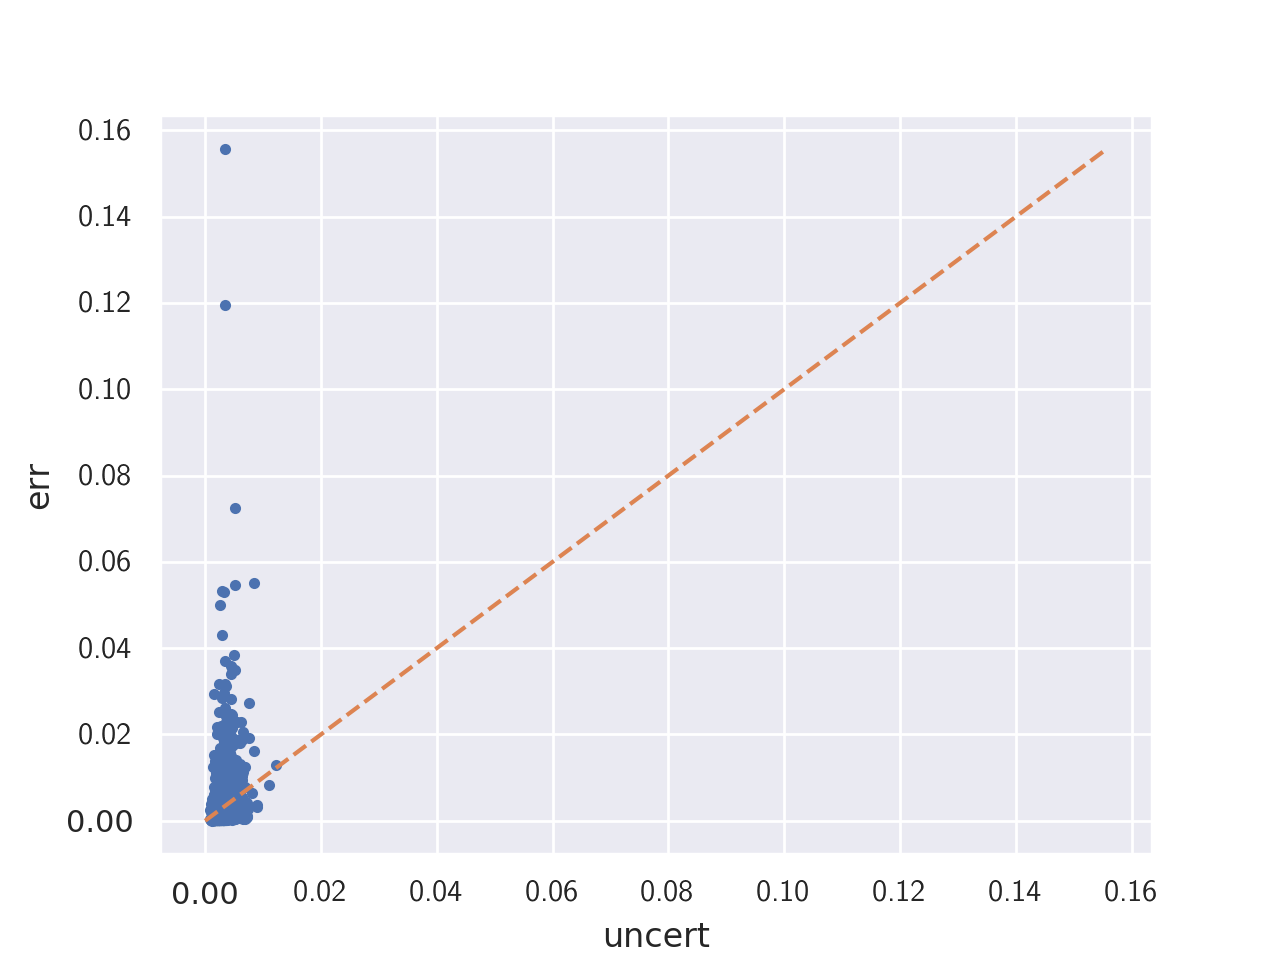

In [13]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu()**2, err_calib.cpu()[:,0]**2, '.')

max_val = max((err_calib**2).max().item(), (uncert_calib**2).max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

In [14]:
# calculate optimal T
S = (err_calib**2 / uncert_calib**2).mean().sqrt()
print(S)

tensor(1.1115, device='cuda:0')


In [15]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))

    def forward(self, x):
        return self.S.mul(x)

In [16]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-2, max_iter=2000)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

1.0531868934631348


In [17]:
aux = AuxModel(1).to(device)
loss = train_aux(aux, nll_criterion_gaussian, mu_calib, uncert_calib, target_calib)
print(loss)

-4.73601770401001


In [18]:
aux.train()
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, (S*uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib).item())
aux.eval()

-4.731429100036621
-4.73049259185791
-4.736529350280762
-4.73601770401001


AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [19]:
print(torch.nn.functional.mse_loss(uncert_calib**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_calib)**2, err_calib**2, reduction='sum').item())

0.09932464361190796
0.09793633222579956
0.09837736189365387
0.09846825897693634


<IPython.core.display.Javascript object>


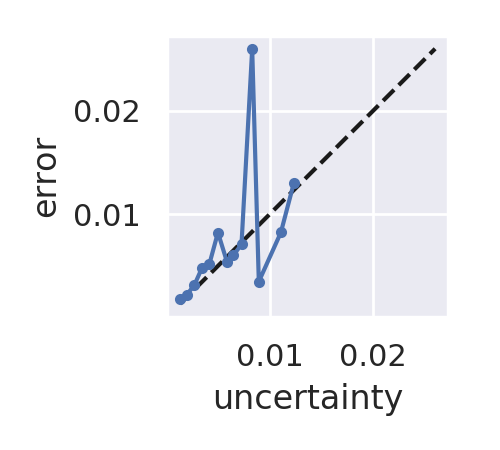

tensor([0.0008], device='cuda:0')


In [20]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, uncert_calib**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce)
plt.show()

<IPython.core.display.Javascript object>


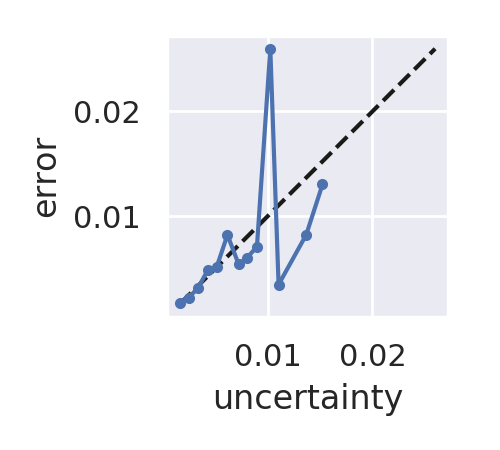

0.0004435431328602135


In [21]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, (S*uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())
plt.show()

<IPython.core.display.Javascript object>


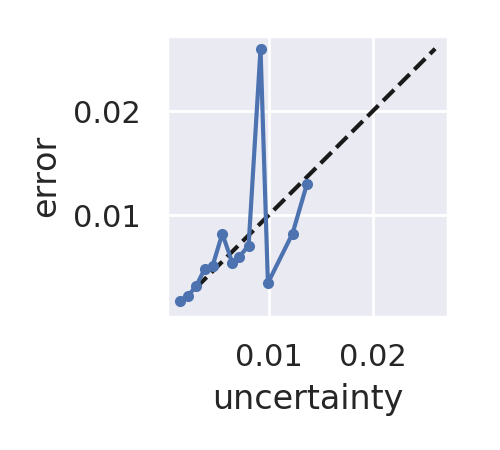

0.0005472685443237424


In [22]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, scaler(uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item())
#fig, ax = plot_frequency(scaler(uncert_calib).cpu(), freq_in_bin.cpu())
#fig.show()

<IPython.core.display.Javascript object>


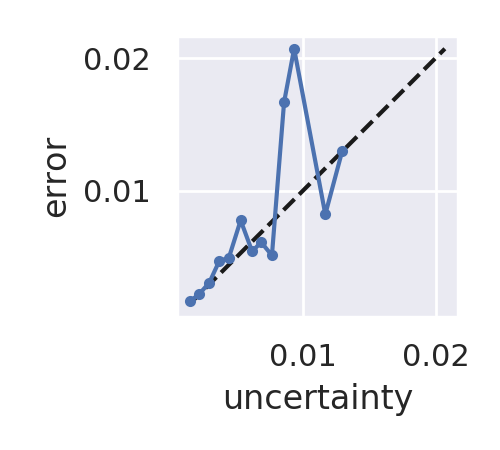

0.0005495526711456478


In [23]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux(uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item())

In [78]:
y_p_test = []
mus_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

        y_p_test.append(y_p.detach())
        vars_test.append(var_bayesian.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

    y_p_test = torch.cat(y_p_test, dim=1).clamp(0, 1).permute(1,0,2)
    mu_test = y_p_test.mean(dim=1)
    var_test = torch.cat(vars_test, dim=0)
    logvars_test = torch.cat(logvars_test, dim=1).permute(1,0,2)
    logvar_test = logvars_test.mean(dim=1)
    target_test = torch.cat(targets_test, dim=0)

100%|██████████| 250/250 [09:43<00:00,  2.33s/it]


In [79]:
err_test = (target_test-mu_test).pow(2).mean(dim=1, keepdim=True).sqrt()
errvar_test = (y_p_test-target_test.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

uncert_aleatoric_test = logvar_test.exp().mean(dim=1, keepdim=True)
uncert_epistemic_test = var_test.mean(dim=1, keepdim=True)

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)

In [80]:
print(err_test.mean())
print(uncert_test.mean())
print(errvar_test.mean())

tensor(0.0456, device='cuda:0')
tensor(0.0548, device='cuda:0')
tensor(0.0039, device='cuda:0')


In [81]:
aux.train()
print(nll_criterion_gaussian(mu_test, uncert_test.pow(2).log(), target_test).item())
print(nll_criterion_gaussian(mu_test, (S*uncert_test).pow(2).log(), target_test).item())
print(nll_criterion_gaussian(mu_test, scaler(uncert_test).pow(2).log(), target_test).item())
print(nll_criterion_gaussian(mu_test, aux(uncert_test), target_test).item())
aux.eval();

-4.758878231048584
-4.753829479217529
-4.761854648590088
-4.760704517364502


In [82]:
print(torch.nn.functional.mse_loss(uncert_test**2, err_test**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_test)**2, err_test**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_test)**2, err_test**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_test)**2, err_test**2, reduction='sum').item())

0.1855224072933197
0.18413075804710388
0.18426667153835297
0.18463987112045288


<IPython.core.display.Javascript object>


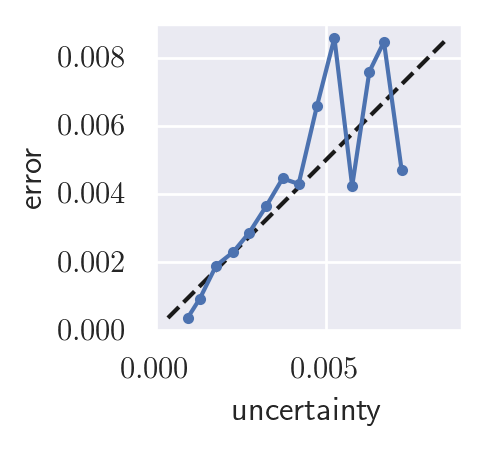

0.08818233013153076


In [83]:
n_bins = 15
uce_uncal, _, _, _ = uceloss(err_test*2, uncert_test**2, n_bins=n_bins)
_, err_uncal, sigma_uncal, _ = uceloss(err_test**2, uncert_test**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_uncal.cpu(), sigma_uncal.cpu())
print(uce_uncal.item())

<IPython.core.display.Javascript object>


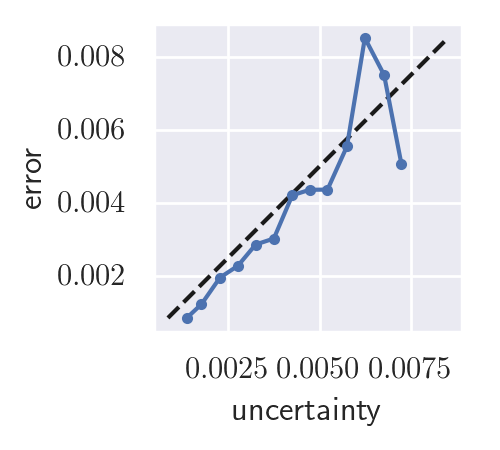

0.0005869688466191292


In [84]:
uce, _, _, _ = uceloss(err_test**2, (S*uncert_test)**2, n_bins=n_bins)
_, err_in_bin, avg_sigma_in_bin, _ = uceloss(err_test**2, (S*uncert_test)**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())

tensor(0.0135, device='cuda:0', grad_fn=<MaxBackward1>)


<IPython.core.display.Javascript object>


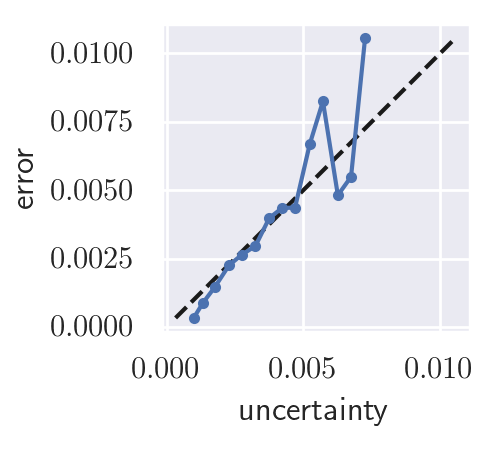

0.0003436441475059837


In [85]:
print((scaler(uncert_test)**2).max())
uce_cal, _, _, _ = uceloss(err_test**2, scaler(uncert_test)**2, n_bins=n_bins)
_, err_cal, sigma_cal, in_bin = uceloss(err_test**2, scaler(uncert_test)**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_cal.cpu(), sigma_cal.cpu())
plt.show()
print(uce_cal.item())
#fig, ax = plot_frequency(scaler(uncert_test).cpu(), in_bin.cpu(), n_bins=n_bins)
fig.show()

tensor(0.0129, device='cuda:0', grad_fn=<MaxBackward1>)


<IPython.core.display.Javascript object>


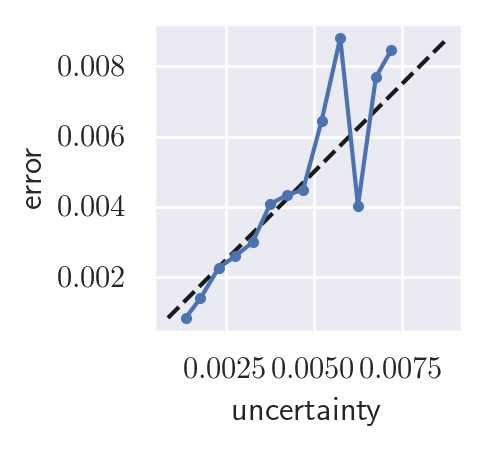

0.00037249407614581287


In [86]:
print((aux(uncert_test)**2).max())
uce_aux, _, _, _ = uceloss(err_test**2, aux(uncert_test)**2, n_bins=n_bins)
_, err_aux, sigma_aux, freq_in_bin = uceloss(err_test**2, aux(uncert_test)**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_aux.cpu(), sigma_aux.cpu())
plt.show()
print(uce_aux.item())

# Unreliable Predictions

The subsequent figure shows the mean MSE after rejecting all predictions, where uncert > uncert_max. The shadow width visualizes the percentage of rejected samples. On the very right side of the plot, the width represents 100 % of the test set samples.

In [87]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [88]:
e_s_list = []
u_s_list = []
t_s_list = []
num_rejected_s = []
uncert_s = scaler(uncert_test)**2

for thresh in np.linspace(uncert_s.max().item(), uncert_s.min().item(), 100)[:-1]:
    e = (err_test**2)[torch.where(uncert_s < thresh)]
    u = uncert_s[torch.where(uncert_s < thresh)]

    t_s_list.append(thresh)
    e_s_list.append(e.mean().item())
    u_s_list.append(u.mean().item())
    num_rejected_s.append((err_test.shape[0]-e.shape[0])/err_test.shape[0])

t_s_list = np.array(t_s_list)
e_s_list = np.array(e_s_list)
u_s_list = np.array(u_s_list)
num_rejected_s = np.array(num_rejected_s)

<IPython.core.display.Javascript object>


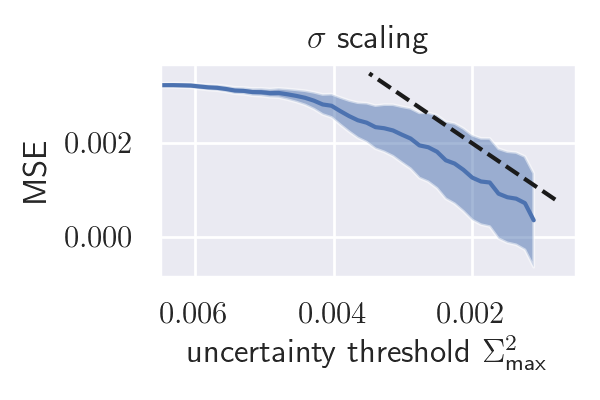

In [89]:
fig, ax = plt.subplots(1, figsize=(3.0, 2.0))

ax.plot([0.0008, e_s_list.max()], [0.0008, e_s_list.max()], 'k--')
ax.plot(t_s_list, e_s_list)
ax.fill_between(t_s_list, e_s_list-num_rejected_s/1000, e_s_list+num_rejected_s/1000, alpha=0.5)
ax.set_xlim(
    #ax[0].get_xlim()[1],
    0.0065,
    0.0005)
ax.set_xlabel(r'uncertainty threshold $ \Sigma^2_{\mathsf{max}} $')
ax.set_ylabel(r'MSE')
ax.set_title(r'$ \sigma $ scaling')

fig.tight_layout()
fig.show()
fig.savefig(f"rejection_s_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)

# OOD Detection

In [90]:
y_ps_ood = []
mus_ood = []
vars_ood = []
logvars_ood = []
targets_ood = []

for s in range(3):
    y_p_test = []
    mus_test = []
    vars_test = []
    logvars_test = []
    targets_test = []
    
    if s < 2:
        loader = test_loader
    elif s == 2:
        loader = test_loader_breastpathq
    else:
        assert False

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(loader)):
            data, target = data.to(device), target.to(device)
            
            if s == 1:
                d_min, d_max = data.min(), data.max()
                data = (data - d_min)*2/(d_max-d_min)
                data -= 1
                data_np = data.cpu().numpy()
                data_np = [clahe(data_np[i,0], clip_limit=0.03) for i in range(data.size(0))] 
                data = torch.FloatTensor(np.array(data_np)).to(device).unsqueeze(1)
                data += 1
                data = data/2*(d_max-d_min)+(d_min)
            elif s == 2:
                data = ((data[:,0] + data[:,1] + data[:,2])/3).unsqueeze(1)

            y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

            y_p_test.append(y_p.detach())
            vars_test.append(var_bayesian.detach())
            logvars_test.append(logvar.detach())
            targets_test.append(target.detach())

        y_p_test = torch.cat(y_p_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = y_p_test.mean(dim=1)
        var_test = torch.cat(vars_test, dim=0)
        logvars_test = torch.cat(logvars_test, dim=1).permute(1,0,2)
        logvar_test = logvars_test.mean(dim=1)
        target_test = torch.cat(targets_test, dim=0)

        y_ps_ood.append(y_p_test)
        mus_ood.append(mu_test)
        vars_ood.append(var_test)
        logvars_ood.append(logvar_test)
        targets_ood.append(target_test)

100%|██████████| 38/38 [01:13<00:00,  1.93s/it]


In [91]:
errs_ood = []
uncerts_ood = []

for i in range(len(y_ps_ood)):
    err_test = (targets_ood[i]-mus_ood[i]).pow(2).mean(dim=1, keepdim=True).sqrt()
    errvar_test = (y_ps_ood[i]-targets_ood[i].unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

    uncert_aleatoric_test = logvars_ood[i].exp().mean(dim=1, keepdim=True)
    uncert_epistemic_test = vars_ood[i].mean(dim=1, keepdim=True)

    if uncertainty == 'aleatoric':
        uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
    elif uncertainty == 'epistemic':
        uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
    else:
        uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)

    uncerts_ood.append(uncert_test.detach().cpu().numpy())
    errs_ood.append(errvar_test.detach().cpu().numpy())

<IPython.core.display.Javascript object>


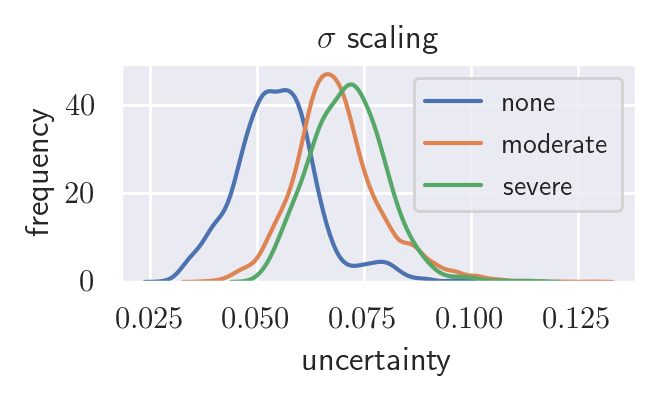

In [92]:
fig, ax = plt.subplots(figsize=(3.3, 2.0))

labels = [r'none', r'moderate', r'severe']

for i in range(len(uncerts_ood)):
    data = uncerts_ood[i][np.where(uncerts_ood[i] < 0.8)]
    sns.distplot(data, hist_kws={'stacked': True}, kde=True, hist=False, norm_hist=True,
                 label=labels[i],
                 ax=ax)

ax.legend(prop={'size': 10})
#ax.set_ylim([-30, 430])
#ax.set_xticks([0, 0.005, 0.01])
ax.set_xlabel(r'uncertainty')
ax.set_ylabel(f'frequency')
ax.set_title(f'$ \sigma $ scaling')
fig.tight_layout()
fig.show()
fig.savefig(f"ood_boneage_s_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)